# Trabajo Práctico 1
## Gimenez, García Vence, Morita y Yapoudjian


Importamos librerías necesarias para poder trabajar con los datos.

In [50]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import math
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar los datos
data = pd.read_csv('Wind_Data.csv')
data.head()


,dia,regional wind,wind gap norte sur
0,1,8.000000,0.000000
1,2,8.346296,0.181523
2,3,10.062316,0.188643
3,4,10.791337,0.071085
4,5,10.754093,0.078442


Calculamos el incremento diario como el viento en i menos el viento en i-1:

In [51]:
def daily_dif(current_wind, previous_wind):
    # Calcular el incremento como la diferencia entre los vientos
    return (current_wind - previous_wind)

# Calcular incremento diario
data['wind_increase'] = daily_dif(data['regional wind'], data['regional wind'].shift(1))
data.head()


,dia,regional wind,wind gap norte sur,wind_increase
0,1,8.000000,0.000000,NaN
1,2,8.346296,0.181523,0.346296
2,3,10.062316,0.188643,1.716019
3,4,10.791337,0.071085,0.729021
4,5,10.754093,0.078442,-0.037244


Definimos *delta* y *theta* (ambos salen de la fórmulas):

In [52]:
# Definir delta
delta = 1/365

# Definir la θ(t)
def theta(i):
    return 6 + 2 * math.cos(2*math.pi * (i-1)/365)

# Calcular θ(t) para cada día
data['theta'] = data['dia'].apply(theta)
data.head()


,dia,regional wind,wind gap norte sur,wind_increase,theta
0,1,8.000000,0.000000,NaN,8.000000
1,2,8.346296,0.181523,0.346296,7.999704
2,3,10.062316,0.188643,1.716019,7.998815
3,4,10.791337,0.071085,0.729021,7.997334
4,5,10.754093,0.078442,-0.037244,7.995261


# Ejercicio 1
## Estimación de parámetros:

Para la realización de este ejercicio hicimos la estimación de los parámetros mediante una *Regresión Lineal*. En ambos casos utilizamos la formulas provistas en clase para transformarlas en un modelo lineal. 

En el caso de *kappa* y *sigma* utilizamos la fórmula:
$$
S_{i+1} = S_i + \kappa (\theta(t_i) - S_i) \Delta + \sigma \sqrt{\Delta} Z_i
$$

y transformamos en:

$$
S_{i+1} - S_i  = \kappa (\theta(t_i) - S_i) \Delta + \sigma \sqrt{\Delta} Z_i
$$

y luego rescribimos como:

$$
y_i  = \kappa x_i + c Z_i 
$$

donde
$$
y_i  = S_{i+1} - S_i
$$
$$
x_i  = (\theta(t_i) - S_i) \Delta
$$
$$
c  = \sigma \sqrt{\Delta}
$$

Teniendo así, calculando la regresión y obteniendo los coeficientes podemos despejar todos los parámetros que buscamos. *Kappa* lo conseguimos del primer coeficiente, y *sigma* lo sacamos de despejar c consiguiendo la varianza del error (ya que el desvio estandar de Zi * c da como resultado c).

In [53]:
s_i = data['regional wind'].shift(1)
theta = data['theta']
X = ((theta - s_i) * delta)[1:].values
Y = (data['wind_increase'])[1:].values

# Modelo de regresión lineal
reg = LinearRegression().fit(X.reshape(-1, 1), Y)

# Predicciones y error
Y_pred = reg.predict(X.reshape(-1, 1))
error = Y - Y_pred

# Cálculo de kappa y sigma con error de estimación
kappa = reg.coef_[0]
c = np.sqrt(error.var())
sigma = c / np.sqrt(delta)

# Error estándar de σ
sigma_error = sigma / np.sqrt(2 * len(error))

# Error estándar de kappa
kappa_error = np.sqrt(np.sum((error - np.mean(error))**2) / (len(error) - 2)) / np.sqrt(np.sum(X**2))

print(f"κ: {kappa}, Error de κ: {kappa_error}")
print(f"σ: {sigma}, Error de σ: {sigma_error}")



κ: 109.04125628331572, Error de κ: 4.294413913397189
σ: 16.04457314539312, Error de σ: 0.18781325432638485


En el caso de *beta* y *gamma* utilizamos la fórmula:
$$
D_{i+1} = D_i - \beta D_i \Delta + \gamma \sqrt{\Delta} W_i
$$

y transformamos en:

$$
D_{i+1} - D_i  = - \beta D_i \Delta + \gamma \sqrt{\Delta} W_i
$$

y luego rescribimos como:

$$
y_i  = \beta x_i + c W_i 
$$

donde
$$
y_i  = D_{i+1} - D_i
$$
$$
x_i  = - D_i \Delta
$$
$$
c  = \gamma \sqrt{\Delta}
$$

Teniendo así, calculando la regresión y obteniendo los coeficientes podemos despejar todos los parámetros que buscamos. *beta* lo conseguimos del primer coeficiente, y *gamma* lo sacamos de despejar c consiguiendo la varianza del error (ya que el desvio estandar de Wi * c da como resultado c).

In [54]:
# Creamos 'gap_dif' como la diferencia diaria del gap del viento entre el norte y sur
data['gap_dif'] = data['wind gap norte sur'] - data['wind gap norte sur'].shift(1)
data.head()

# Definimos variables para wind gap
Y_gap = (data['gap_dif'])[1:].values
d_i = data['wind gap norte sur'].shift(1)
X_gap = (d_i * delta)[1:].values

# Ajustar el modelo de regresión lineal para el wind gap
reg_gap = LinearRegression().fit(X_gap.reshape(-1, 1), Y_gap)

# Predecimos y calculamos error
Y_pred_gap = reg_gap.predict(X_gap.reshape(-1, 1))
error_gap = Y_gap - Y_pred_gap

# Cálculo de beta y gamma y su error de estimación
beta = -(reg_gap.coef_[0])
gamma = np.sqrt(error_gap.var()) / np.sqrt(delta)

# Error estándar de gamma
gamma_error = gamma / np.sqrt(len(error_gap))

# Error estándar de beta
beta_error = np.sqrt(np.sum((error_gap - np.mean(error_gap))**2) / (len(error_gap) - 2)) / np.sqrt(np.sum(X_gap**2))

print(f"β: {beta}, Error de β: {beta_error}")
print(f"γ: {gamma}, Error de γ: {gamma_error}")

β: 48.37733323194379, Error de β: 3.0057533121947224
γ: 10.090719957138331, Error de γ: 0.1670456696712918


# Ejercicio 2

Para este ejercicio, decidimos simular el viento mediante una función llamada *wind_path*. Pasamos los parámetros para simular viento regional y el gap, simulamos Wi y Zi (Normales 0,1) y calculamos cada día (Desde 0 hasta T).

Luego teniendo S y D, calculamos viento norte como
$$
S - D/2 
$$
viento sur como 
$$
S + D/2
$$

Luego, graficamos los resultados para contrastar con el histórico.

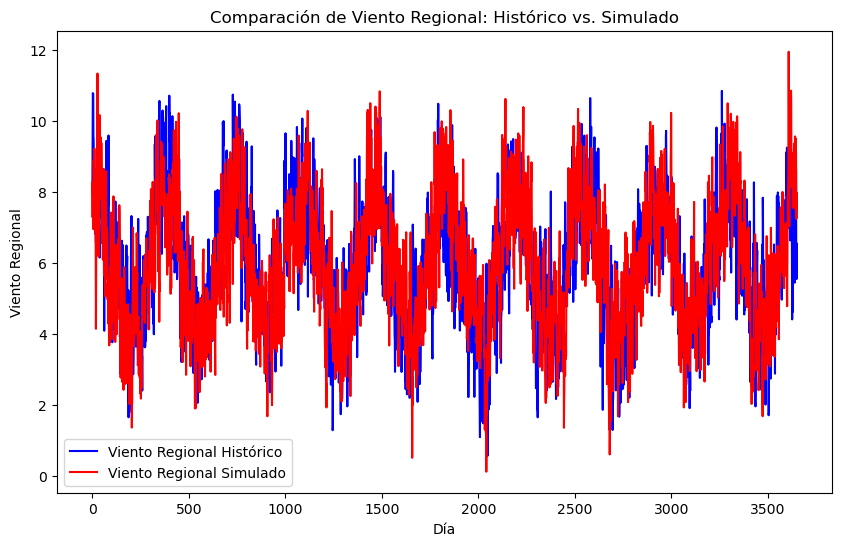

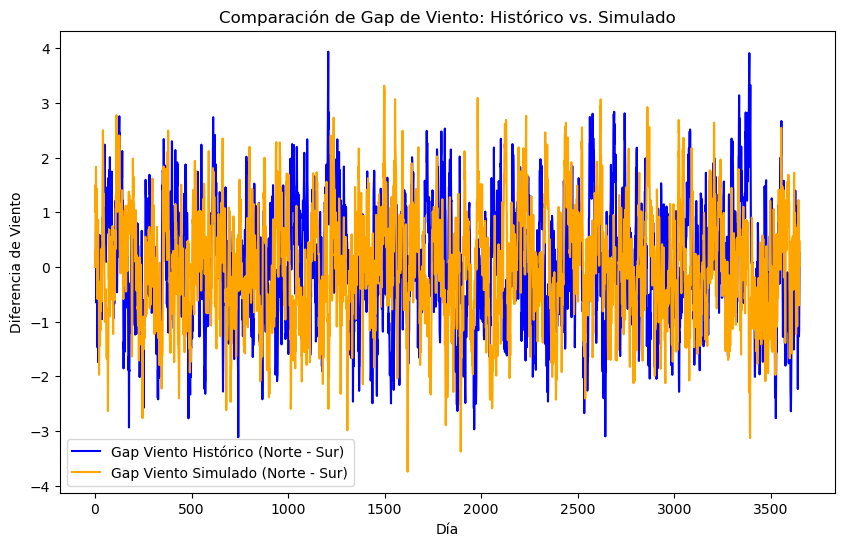

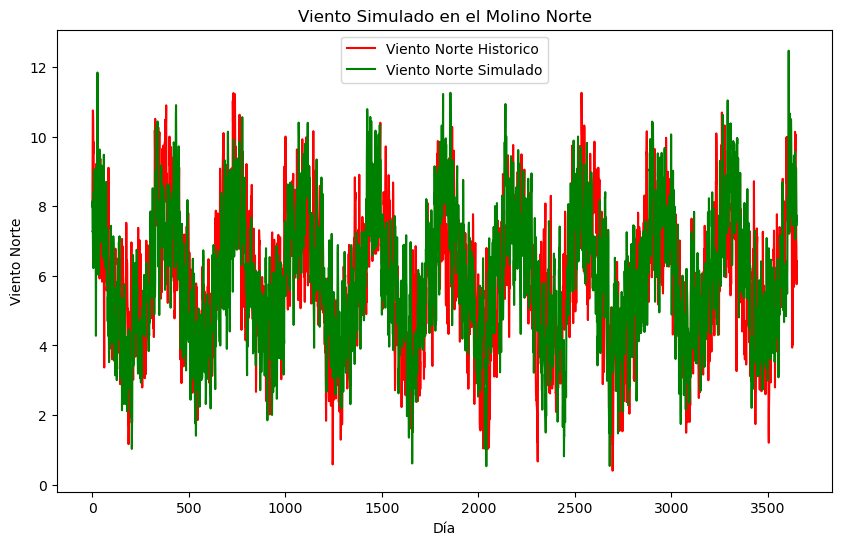

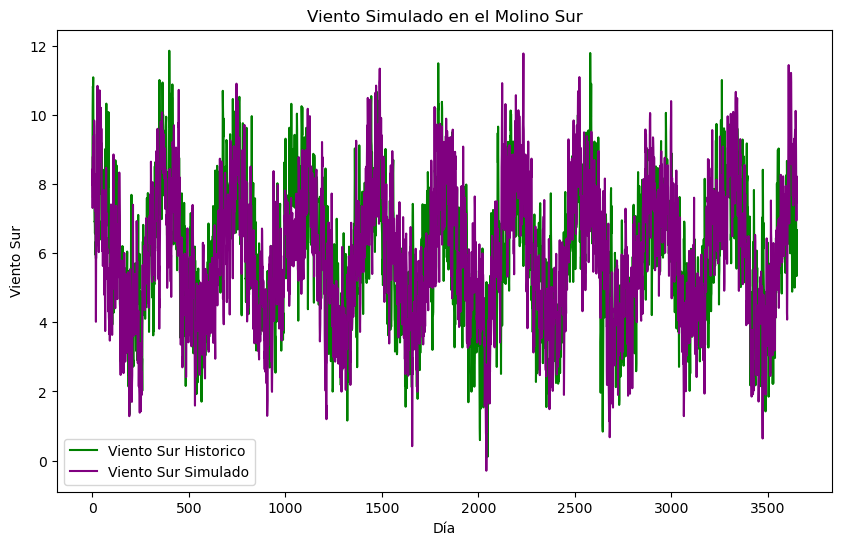

In [55]:
# Función para simular un camino de viento
def wind_path(S_0, D_0, kappa, theta, sigma, delta, beta, gamma, T):
    S = np.full(T, S_0)
    D = np.full(T, D_0)
    for t in range(1, T):
        Z = np.random.normal(0, 1)  # Shock para el viento regional
        W = np.random.normal(0, 1)  # Shock para la diferencia de viento
            
        # Evolución del viento regional
        S[t] = S[t-1] + kappa * (theta[t] - S[t-1]) * delta + np.sqrt(delta) * Z * sigma
            
        # Evolución de la diferencia de viento entre Norte y Sur
        D[t] = D[t-1] - (beta * D[t-1] * delta) + gamma * np.sqrt(delta) * W

    return S, D

# Inicialización de parámetros
S_0 = data['regional wind'].iloc[0]
D_0 = data['wind gap norte sur'].iloc[0]
T = len(data)  # Usamos el mismo número de días que en los datos históricos
delta = 1 / 365  

# Simulamos
S, D = wind_path(S_0, D_0, kappa, theta, sigma, delta, beta, gamma, T)

# Calculamos viento en Norte y Sur
viento_norte = S - D / 2
viento_sur = S + D / 2

#Calculamos viento historico norte y sur
viento_norte_historico = data['regional wind'] - data['wind gap norte sur'] / 2
viento_sur_historico = data['regional wind'] + data['wind gap norte sur'] / 2


# Graficamos el viento regional y simulado
plt.figure(figsize=(10, 6))
plt.plot(data['regional wind'], label='Viento Regional Histórico', color='blue')
plt.plot(S, label='Viento Regional Simulado', color='red')
plt.title('Comparación de Viento Regional: Histórico vs. Simulado')
plt.xlabel('Día')
plt.ylabel('Viento Regional')
plt.legend()
plt.show()

# Graficamos la diferencia de viento (gap) entre Norte y Sur
plt.figure(figsize=(10, 6))
plt.plot(data['wind gap norte sur'], label='Gap Viento Histórico (Norte - Sur)', color='blue')
plt.plot(D, label='Gap Viento Simulado (Norte - Sur)', color='orange')
plt.title('Comparación de Gap de Viento: Histórico vs. Simulado')
plt.xlabel('Día')
plt.ylabel('Diferencia de Viento')
plt.legend()
plt.show()

# Graficamos el viento en el molino Norte
plt.figure(figsize=(10, 6))
plt.plot(viento_norte_historico, label='Viento Norte Historico', color='red')
plt.plot(viento_norte, label='Viento Norte Simulado', color='green')
plt.title('Viento Simulado en el Molino Norte')
plt.xlabel('Día')
plt.ylabel('Viento Norte')
plt.legend()
plt.show()

# Graficamos el viento en el molino Sur
plt.figure(figsize=(10, 6))
plt.plot(viento_sur_historico, label='Viento Sur Historico', color='green')
plt.plot(viento_sur, label='Viento Sur Simulado', color='purple')
plt.title('Viento Simulado en el Molino Sur')
plt.xlabel('Día')
plt.ylabel('Viento Sur')
plt.legend()
plt.show()


Aquí probamos hacer una función para graficar M simulaciones y ver como se diferencian graficando todas ellas:

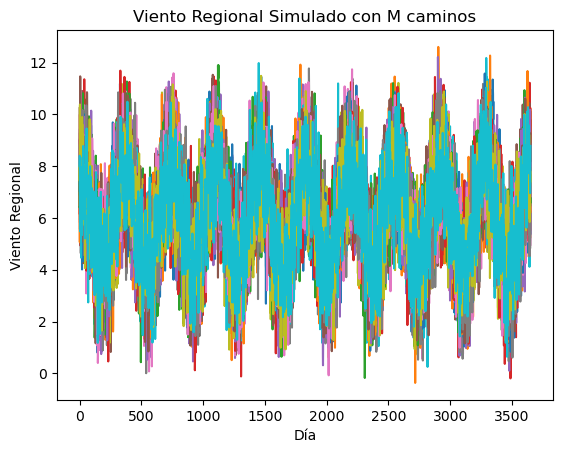

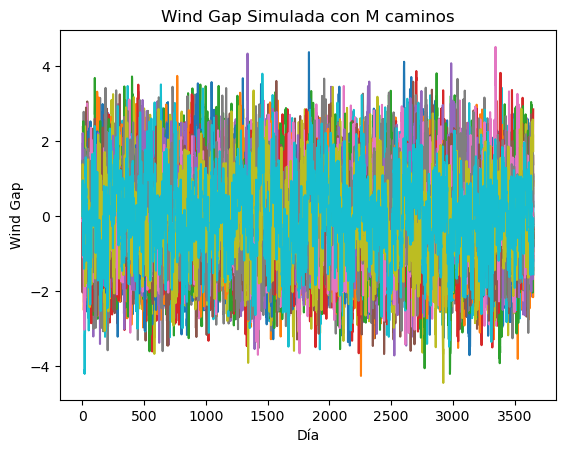

In [56]:
# Función para simular M caminos de viento
def wind_paths(S_0, D_0, kappa, theta, sigma, delta, beta, gamma, T, M):
    S = np.full((M, T), S_0)
    D = np.full((M, T), D_0)
    for j in range (M):
        for t in range(1, T):
            Z = np.random.normal(0, 1)  # Shock para el viento regional
            W = np.random.normal(0, 1)  # Shock para la diferencia de viento
            
            # Evolución del viento regional
            S[j][t] = S[j][t-1] + kappa * (theta[t] - S[j][t-1]) * delta + np.sqrt(delta) * Z * sigma
            
            # Evolución de la diferencia de viento entre Norte y Sur
            D[j][t] = D[j][t-1] - (beta * D[j][t-1] * delta) + gamma * np.sqrt(delta) * W

    return S, D

# Inicialización de parámetros
S_0 = data['regional wind'].iloc[0]
D_0 = data['wind gap norte sur'].iloc[0]
T = len(data)  # Usamos el mismo número de días que en los datos históricos
delta = 1 / 365  
M = 30

# Simulamos
S, D = wind_paths(S_0, D_0, kappa, theta, sigma, delta, beta, gamma, T, M)

# Calculamos viento en Norte y Sur
viento_norte = S - D / 2
viento_sur = S + D / 2

#Calculamos viento historico norte y sur
viento_norte_historico = data['regional wind'] - data['wind gap norte sur'] / 2
viento_sur_historico = data['regional wind'] + data['wind gap norte sur'] / 2

for S_i in S :
  plt.plot(S_i)
  plt.title('Viento Regional Simulado con M caminos')
  plt.xlabel('Día')
  plt.ylabel('Viento Regional')

plt.show()

for D_i in D :
  plt.plot(D_i)
  plt.title('Wind Gap Simulada con M caminos')
  plt.xlabel('Día')
  plt.ylabel('Wind Gap')

plt.show()

# Ejercicio 3 y 4

En este ejercicio, decidimos crear la función *simulate_molino* para generar los diferentes cashflows mediante los vientos obtenidos. En la misma, primero se samplea la probabilidad de que el molino se rompa (si estaba encendido el dia anterior), y luego se define el cashflow del día i y se agregan los diferentes datos como si ese día se rompió, si se había apagado o prendido el molino y demás.

Por último, definimos la función VAN donde pasado una tasa de descuento podemos calcular el VAN según un cashflow dado.


In [57]:
def simulate_molino(S, K, T):
    cash_flow = np.zeros(T)
    roturas = np.zeros(T)
    estados = np.zeros(T)
    estado = 'apagado'
    roto = False
    apagados = np.zeros(T)
    encendidos = np.zeros(T)
    for t in range(0, T):
        if estado == 'encendido':
            prob_falla = 0.25 * (S[t] ** 2) * delta
            if np.random.random() < prob_falla:
                roto = True  # El molino se rompe
                roturas[t]=1
        if roto:
            cash_flow[t] = -200000  # Costo de reparación
            roto = False  # Molino se repara en el mismo día
            estado = 'apagado'  # Se apaga después de repararse
            apagados[t] = 1
        else:
            if S[t] > K and estado == 'encendido':
                cash_flow[t] = -1000  # Costo de apagar
                estado = 'apagado'
                apagados[t] = 1

            elif S[t] <= K and estado == 'apagado':
                cash_flow[t] = 1000 * S[t]  # Encender no cuesta nada
                estado = 'encendido'
                encendidos[t] = 1
                
            if estado == 'encendido':
                ingreso_diario = 1000 * S[t]
                cash_flow[t] = ingreso_diario
        
        if estado == 'apagado':
            estados[t] = 1
        
    return cash_flow, roturas, encendidos, apagados, estados

# Parámetros iniciales
S_0 = data['regional wind'].iloc[0]
D_0 = data['wind gap norte sur'].iloc[0]
T = 365
delta = 1 / 365

# Simulación de viento
S, D = wind_path(S_0, D_0, kappa, theta, sigma, delta, beta, gamma, T)
viento_norte = S - (D / 2) # Generamos Viento Norte
viento_sur = S + (D / 2) # Generamos Viento Sur

# Parámetros de operación
K = 7.5 # Umbral de velocidad de viento para apagar el molino

# Simulación de ganancias de molinos Norte y Sur
cash_flow_norte, roturas_norte, encendidos_norte, apagados_norte, estados_norte = simulate_molino(viento_norte, K, T)
cash_flow_sur, roturas_sur, encendidos_sur, apagados_sur, estados_sur  = simulate_molino(viento_sur, K, T)


# Cálculo del Valor Actual Neto (VAN)
tasa_interes = 0.05
def calcular_van(cash_flows, tasa_interes, T):
    descuento = np.exp(-tasa_interes * np.arange(T) / 365)
    VAN = np.sum(cash_flows * descuento)
    return VAN

# Resultados
VAN_norte = calcular_van(cash_flow_norte, tasa_interes, T)
VAN_sur = calcular_van(cash_flow_sur, tasa_interes, T)
print(f"VAN del Molino Norte: {VAN_norte:.2f} USD")
print(f"VAN del Molino Sur: {VAN_sur:.2f} USD")

VAN del Molino Norte: 36093.57 USD
VAN del Molino Sur: 50476.24 USD


Para seguir con el punto, tenemos todos los gráfico que se nos pidieron.

# Gráficos Molino Norte: 
## 1er Gráfico: Evolución del viento, roturas y diferentes decisiones de prendido y apagado a lo largo de los días.

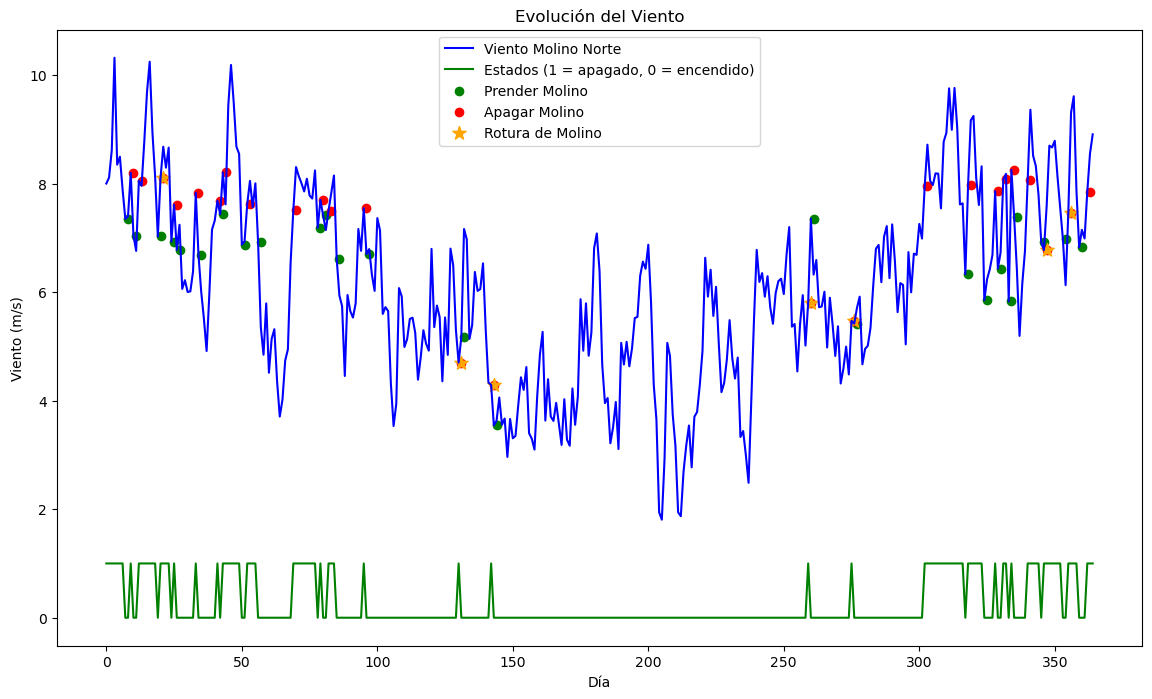

In [58]:
# Gráfico de la evolución del viento con roturas
plt.figure(figsize=(14, 8))
plt.plot(viento_norte,label='Viento Molino Norte', color='blue')
plt.plot(estados_norte, label="Estados (1 = apagado, 0 = encendido)", color = "green")
# Añadir puntos en los días en que se prendió el molino
dias_con_molino_norte = [i + 1 for i in range(len(encendidos_norte)) if encendidos_norte[i] == 1]
viento_con_encendidos_norte = [viento_norte[i] for i in range(len(encendidos_norte)) if encendidos_norte[i] == 1]
# Añadir puntos en los días en que se apagó el molino
dias_apagado_norte = [i + 1 for i in range(len(apagados_norte)) if apagados_norte[i] == 1]
viento_con_apagados_norte = [viento_norte[i] for i in range(len(apagados_norte)) if apagados_norte[i] == 1]
# Añadir puntos en los días en que se rompió el molino
dias_rotura_norte = [i + 1 for i in range(len(roturas_norte)) if roturas_norte[i] == 1]
viento_con_roturas_norte = [viento_norte[i] for i in range(len(roturas_norte)) if roturas_norte[i] == 1]


plt.scatter(dias_con_molino_norte, viento_con_encendidos_norte, color='green', label='Prender Molino')
plt.scatter(dias_apagado_norte, viento_con_apagados_norte, color='red', label='Apagar Molino')
plt.scatter(dias_rotura_norte, viento_con_roturas_norte, color='orange', label='Rotura de Molino', marker='*',s=100)
plt.title('Evolución del Viento')
plt.xlabel('Día')
plt.ylabel('Viento (m/s)')
plt.legend()
plt.show()

## 2ndo Gráfico: Evolución de la acumulación del cashflow a lo largo de los días, en conjunto con los días que se rompió el molino.

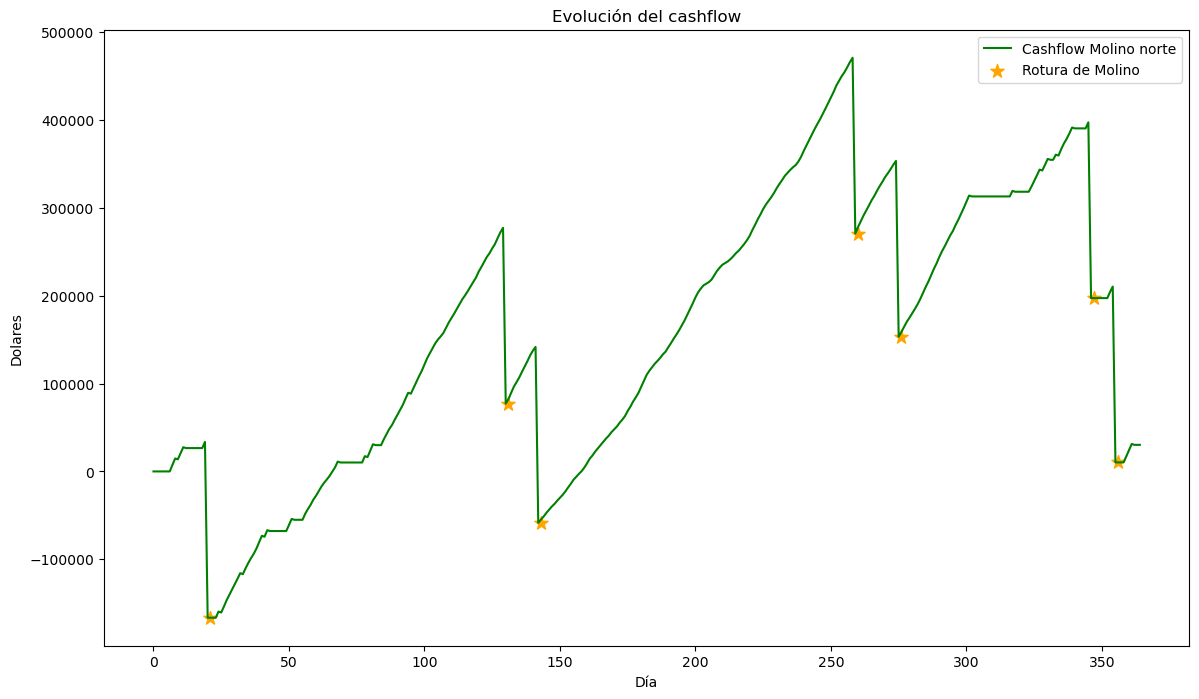

In [59]:
evo_cash_norte = np.cumsum(cash_flow_norte)
# Gráfico de la evolución del viento con roturas
plt.figure(figsize=(14, 8))
plt.plot(evo_cash_norte,label='Cashflow Molino norte', color='green')
# Añadir puntos en los días en que se rompió el molino
roturas_cashflow_norte = [evo_cash_norte[i] for i in range(len(roturas_norte)) if roturas_norte[i] == 1]
plt.scatter(dias_rotura_norte, roturas_cashflow_norte, color='orange', label='Rotura de Molino', marker='*',s=100)
plt.title('Evolución del cashflow')
plt.xlabel('Día')
plt.ylabel('Dolares')
plt.legend()
plt.show()


# Gráficos Molino Sur: 
## 1er Gráfico: Evolución del viento, roturas y diferentes decisiones de prendido y apagado a lo largo de los días.

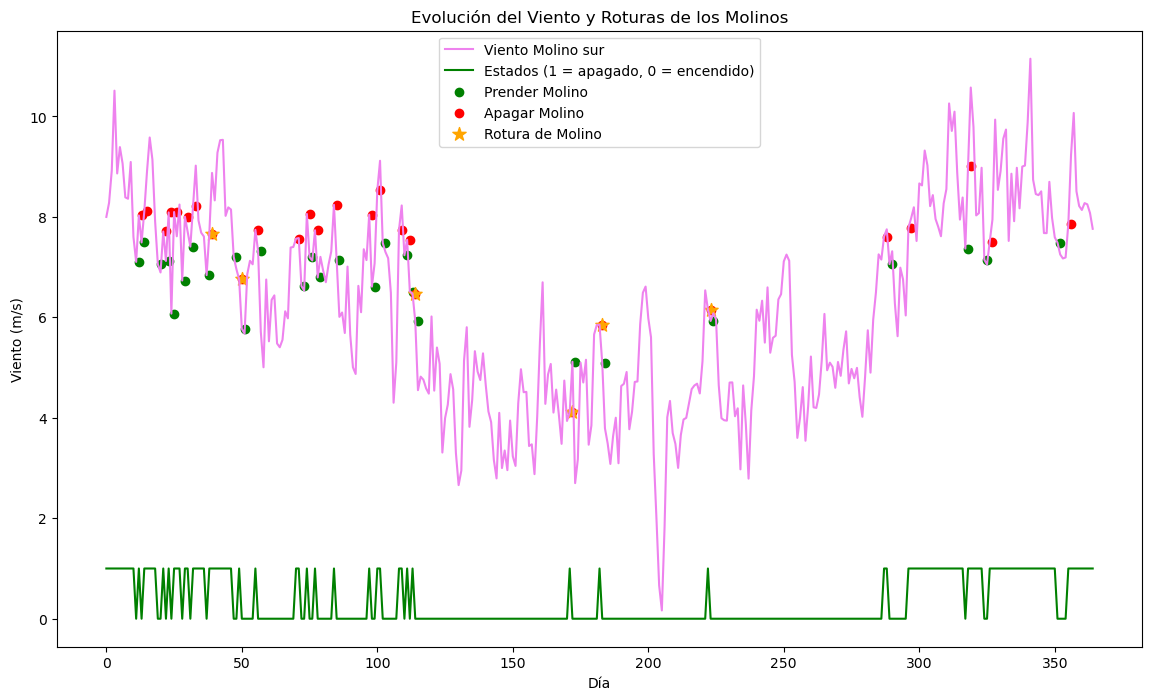

In [60]:
# Gráfico de la evolución del viento con roturas
plt.figure(figsize=(14, 8))
plt.plot(viento_sur,label='Viento Molino sur', color='violet')
plt.plot(estados_sur, label="Estados (1 = apagado, 0 = encendido)", color = "green")
# Añadir puntos en los días en que se prendió el molino
dias_con_molino_sur = [i + 1 for i in range(len(encendidos_sur)) if encendidos_sur[i] == 1]
viento_con_encendidos_sur = [viento_sur[i] for i in range(len(encendidos_sur)) if encendidos_sur[i] == 1]
# Añadir puntos en los días en que se apagó el molino
dias_apagado_sur = [i + 1 for i in range(len(apagados_sur)) if apagados_sur[i] == 1]
viento_con_apagados_sur = [viento_sur[i] for i in range(len(apagados_sur)) if apagados_sur[i] == 1]
# Añadir puntos en los días en que se rompió el molino
dias_rotura_sur = [i + 1 for i in range(len(roturas_sur)) if roturas_sur[i] == 1]
viento_con_roturas_sur = [viento_sur[i] for i in range(len(roturas_sur)) if roturas_sur[i] == 1]


plt.scatter(dias_con_molino_sur, viento_con_encendidos_sur, color='green', label='Prender Molino')
plt.scatter(dias_apagado_sur, viento_con_apagados_sur, color='red', label='Apagar Molino')
plt.scatter(dias_rotura_sur, viento_con_roturas_sur, color='orange', label='Rotura de Molino', marker='*',s=100)
plt.title('Evolución del Viento y Roturas de los Molinos')
plt.xlabel('Día')
plt.ylabel('Viento (m/s)')
plt.legend()
plt.show()

## 2ndo Gráfico: Evolución de la acumulación del cashflow a lo largo de los días, en conjunto con los días que se rompió el molino.

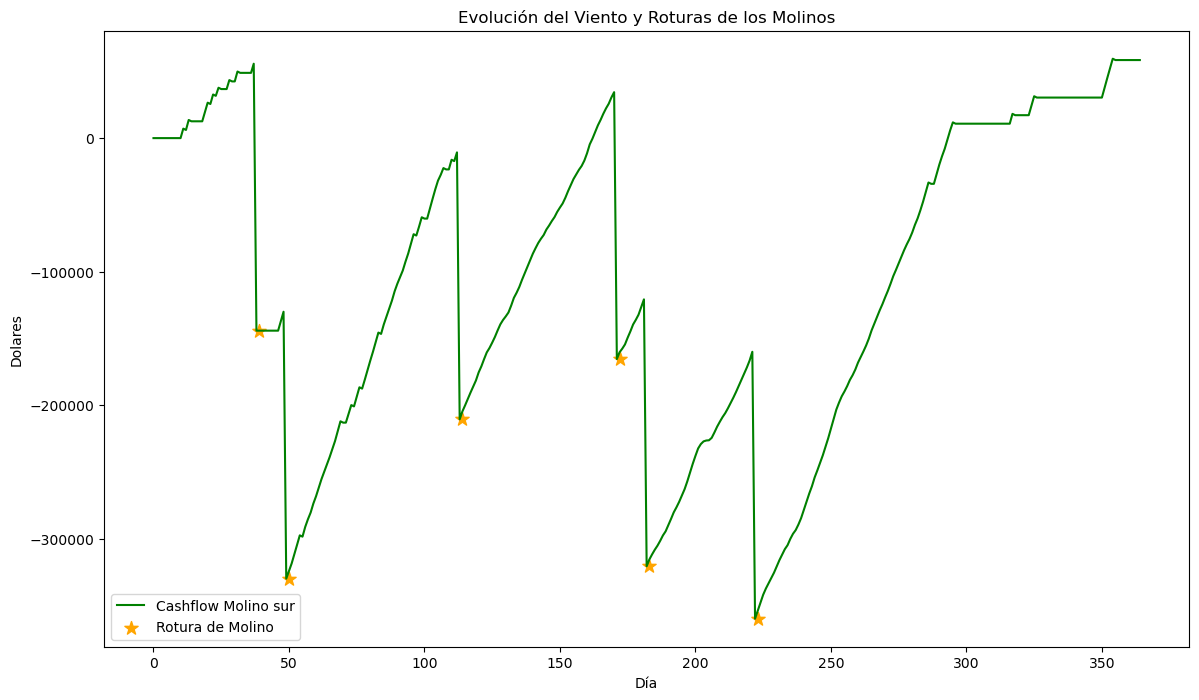

In [61]:
evo_cash_sur = np.cumsum(cash_flow_sur)
# Gráfico de la evolución del viento con roturas
plt.figure(figsize=(14, 8))
plt.plot(evo_cash_sur,label='Cashflow Molino sur', color='green')
# Añadir puntos en los días en que se rompió el molino
roturas_cashflow_sur = [evo_cash_sur[i] for i in range(len(roturas_sur)) if roturas_sur[i] == 1]
plt.scatter(dias_rotura_sur, roturas_cashflow_sur, color='orange', label='Rotura de Molino', marker='*', s=100)
plt.title('Evolución del Viento y Roturas de los Molinos')
plt.xlabel('Día')
plt.ylabel('Dolares')
plt.legend()
plt.show()

Encontramos interesante como se comporta el apagado/prendido del molino según la época de año. Como vemos, en Enero-Febrero y Noviembre-Diciembre los días de molino apagado y decisiones de apagados es muchísimo mas alta que en la mitad del año. 
Esto también acompañado por una cantidad de rupturas mucho mayor. Esto nos hace mucho sentido debido a las diferencias de la medía estacional en los diferentes meses del año. En las epocas de calor, el viento es mayor y genera más rupturas y más decisiones de apagados debido a vientos más altos a nuestro umbral.

# Ejercicio 5

En este ejercicio decidimos estimar el VAN de los molinos mediante la simulación de ~ 10000 simulaciónes para luego estimar mediante Montecarlo la esperanza del VAN y su error estándar. Para esto la función *VAN_estimado_k* generamos cada simulación y sumamos su VAN para luego sacar su promedio y utilizar la fórmula provista en clase como:

$$
\frac{1}{N} \sum_{i=1}^{N} h(profit(Xi,Yi))
$$


Por el Teorema Central del Límite (TCL), converge a:

$$
\mathbb{E}[h(\text{Profit})]
$$


In [62]:
def VAN_estimado_k(num_simulaciones, K):  # Inicializa el mejor K como None
    np.random.seed(20)
    van_total = 0
    van_lista = []
    for i in range(num_simulaciones):
        S, D = wind_path(S_0, D_0, kappa, theta, sigma, delta, beta, gamma, T)
        cash_flow_norte, _, _, _, _ = simulate_molino(S + D / 2, K, T)
        cash_flow_sur, _, _, _, _= simulate_molino(S - D / 2, K, T)
        cash_flow_total = cash_flow_norte + cash_flow_sur
        van = calcular_van(cash_flow_total, tasa_interes, T)  # Calcula el VAN del cash flow total
        van_total = van_total + van
        van_lista.append(van)
    van_total = van_total / num_simulaciones
    std_van = np.std(van_lista)
    error_estandar = std_van / np.sqrt(num_simulaciones)
    return van_total, std_van, error_estandar

# Ejecutar la función
num_simulaciones = 10000
k = 9
van_K, std_van_K, error_estandar_K = VAN_estimado_k(num_simulaciones, K)

print(f"El VAN promedio es: {van_K:.2f} USD")
print(f"La desviación estándar es: {std_van_K:.2f} USD")
print(f"El error estándar es: {error_estandar_K:.2f} USD")

KeyboardInterrupt: 

# Ejercicio 6:

Para poder realizar este ejercicio tomamos una forma muy parecida al ejercicio pasado pero iterando sobre diferentes K para quedarnos con el VAN con mayor valor. Los umbrales K van desde 1 hasta 13 en salto de 0.25. Umbrales mayores a 13 carecen de sentido ya que el viento nunca llega a esos valores.

In [36]:
def k_optimo(num_simulaciones):
    np.random.seed(20)
    k_max = None  # Inicializa el mejor K como None
    van_max = -np.inf  # Inicializa el VAN máximo como un valor muy bajo
    error_estandar_max = 0  
    for k in np.arange(1, 13, 0.25):
        van_lista = []  # Lista para almacenar los VAN de cada simulación
        for i in range(num_simulaciones):
            S, D = wind_path(S_0, D_0, kappa, theta, sigma, delta, beta, gamma, T)
            cash_flow_norte, _, _, _, _ = simulate_molino(S + D / 2, k, T)
            cash_flow_sur, _, _, _, _ = simulate_molino(S - D / 2, k, T)
            cash_flow_total = cash_flow_norte + cash_flow_sur
            van = calcular_van(cash_flow_total, tasa_interes, T)  # Calcula el VAN del cash flow total
            van_lista.append(van)
        
        van_total = np.mean(van_lista)  
        std_van = np.std(van_lista)  
        error_estandar = std_van / np.sqrt(num_simulaciones) 
        
        if van_total > van_max:  
            van_max = van_total
            k_max = k
            error_estandar_max = error_estandar

    return k_max, van_max, error_estandar_max

# Ejecutar la función
num_simulaciones = 10000
k_max, van_promedio, error_estandar_max = k_optimo(num_simulaciones)

# Mostrar resultados
print(f"El umbral K óptimo promedio es: {k_max}")
print(f"El VAN promedio es: {van_promedio:.2f} USD")
print(f"El error estándar del VAN óptimo es: {error_estandar_max:.2f} USD")


El umbral K óptimo promedio es: 7.5
El VAN promedio es: 508572.64 USD
El error estándar del VAN óptimo es: 6592.60 USD


Vemos un umbral de 7.5 (puede variar segun la simulación en 0.25). Vemos que tiene sentido ya que se encuentra en un 'punto medio' entre arriesgar mucho umbral (y poder tener muchas roturas) y tener un umbral bajo (y no generar beneficio y/o apagar mucho el molino).

# Ejercicio 7:

Aquí nuestra operativa fue comparar nuestro óptimo y calcular el ingenuo mediante un umbral altísimo (K=30) ya que el viento nunca va a llegar a esos niveles.

In [37]:
num_simulaciones=10000
# Opción Ingenua -> Elegimos un K muy alto, por lo que nunca vamos a apagar los molinos
K=30
# Ejecutar la función con K = 30 (nunca llega)
van_K, std_van_K, error_estandar_K = VAN_estimado_k(num_simulaciones, K)
print(f"El VAN promedio es: {van_K:.2f} USD con método ingenuo")
print(f"El Error estándar  es: {error_estandar_K:.2f} USD con método ingenuo")

K=k_max
# Ejecutar la función con K = 7.75
van_K_max, std_van_K_max, error_estandar_K_max = VAN_estimado_k(num_simulaciones, K)
print(f"El VAN promedio es: {van_K_max:.2f} USD con K óptimo")
print(f"El Error estándar  es: {error_estandar_K_max:.2f} USD con K óptimo")

El VAN promedio es: 413570.40 USD con método ingenuo
El Error estándar  es: 8441.80 USD con método ingenuo
El VAN promedio es: 507315.98 USD con K óptimo
El Error estándar  es: 6612.43 USD con K óptimo


Vemos que tiene sentido nuestro resultado: El método ingenuo es peor (y tiene mayor error) que el óptimo. Creemos que el mayor error se debe al incremento de posibilidades de roturas de molinos (podemos tener escenarios donde no se rompen y ganar mucho, o escenarios donde se rompe siempre).

# Ejercicio 8


En este ejercicio nuestra idea fue quedarnos exclusivamente con los ingresos de Agosto simulando muchas observaciones y ver como se comportan graficandolas, viendo sus cuantiles y graficando un boxplot.

In [38]:
def simulate_molino_ingresos(S, K, T):
    cash_flow = np.zeros(T)
    roturas = np.zeros(T)
    estados = np.zeros(T)
    estado = 'apagado'
    roto = False
    apagados = np.zeros(T)
    encendidos = np.zeros(T)
    for t in range(0, T):
        if estado == 'encendido':
            prob_falla = 0.25 * (S[t] ** 2) * delta
            if np.random.random() < prob_falla:
                roto = True  # El molino se rompe
                roturas[t]=1
        if roto:
            cash_flow[t] = 0  # Costo de reparación
            roto = False  # Molino se repara en el mismo día
            estado = 'apagado'  # Se apaga después de repararse
            apagados[t] = 1
        else:
            if S[t] > K and estado == 'encendido':
                cash_flow[t] = 0 # Costo de apagar
                estado = 'apagado'
                apagados[t] = 1

            elif S[t] <= K and estado == 'apagado':
                cash_flow[t] = 1000 * S[t]  # Encender no cuesta nada
                estado = 'encendido'
                encendidos[t] = 1
                
            if estado == 'encendido':
                ingreso_diario = 1000 * S[t]
                cash_flow[t] = ingreso_diario
        
        if estado == 'apagado':
            estados[t] = 1
        
    return cash_flow

El estimación del ingreso de agosto es: 300915.29 USD
El desvio estándar es: 23341.89 USD
La varianza es: 544843841.54 USD
Cuantiles:
 0.25    286168.090269
0.50    302355.176387
0.75    317377.033171
dtype: float64


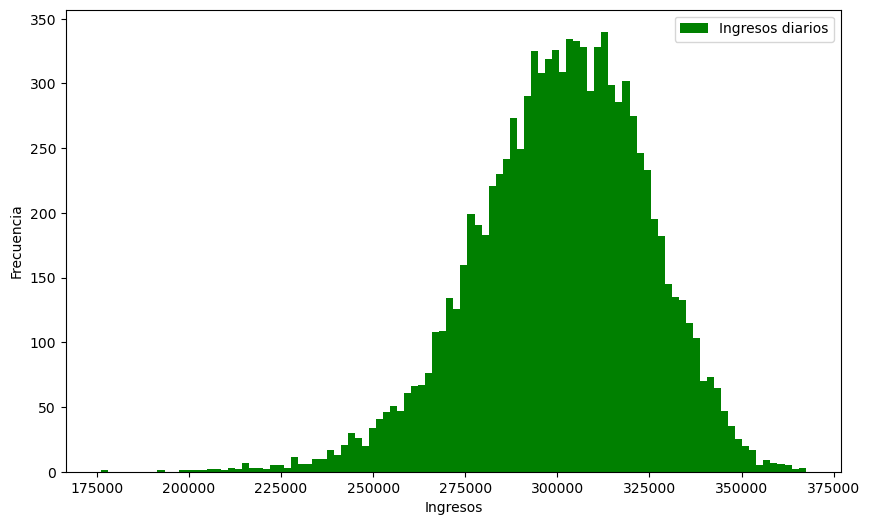

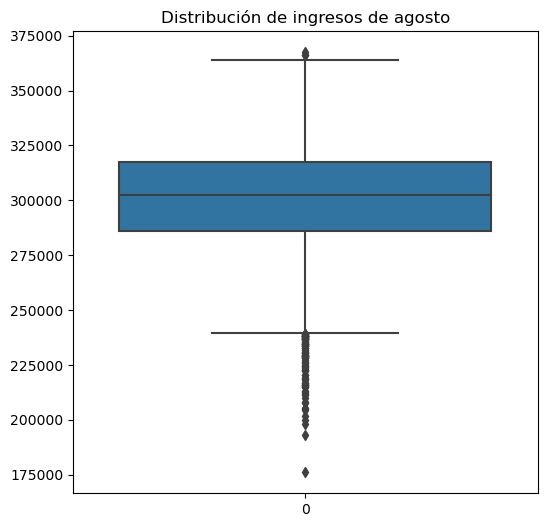

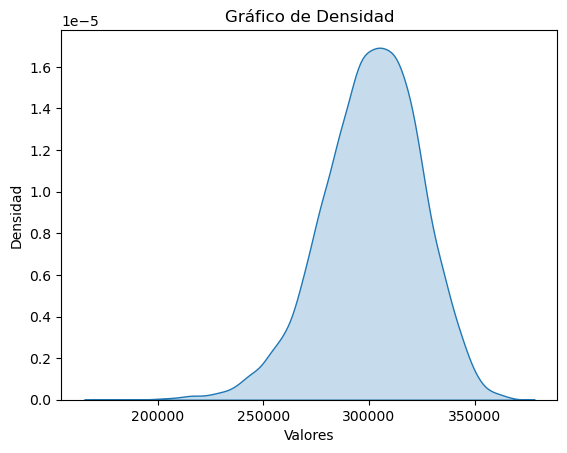

In [39]:
def ingresos_agosto(k_optimo, T= 365, num_simulaciones= 10000):
    ingresos = []
    np.random.seed(244)
    for _ in range(num_simulaciones):
        S, D = wind_path(S_0, D_0, kappa, theta, sigma, delta, beta, gamma, T)
        ingresos_norte = simulate_molino_ingresos(S + D / 2, k_optimo, T)
        ingresos_sur= simulate_molino_ingresos(S - D / 2, k_optimo, T)
        ingresos_total = ingresos_norte + ingresos_sur
        ingresos_agosto = sum(ingresos_total[244:275])  # Agosto es del día 244 al 275
        ingresos.append(ingresos_agosto)

    return ingresos

ingresos_agosto = ingresos_agosto(k_max)

varianza_agosto = np.var(ingresos_agosto)
desvio_agosto = np.std(ingresos_agosto)
error_estandar_agosto = desvio_agosto / np.sqrt(num_simulaciones)
estimacion_agosto = np.mean(ingresos_agosto)

print(f"El estimación del ingreso de agosto es: {estimacion_agosto:.2f} USD")
print(f"El desvio estándar es: {desvio_agosto:.2f} USD")
print(f"El error estándar es: {error_estandar_agosto:.2f} USD")
print(f"La varianza es: {varianza_agosto:.2f} USD")

serie = pd.Series(ingresos_agosto)
cuantiles = serie.quantile([0.25, 0.5, 0.75])
print("Cuantiles:\n", cuantiles)


plt.figure(figsize=(10, 6))
plt.hist(ingresos_agosto, bins = 100, color='g', label='Ingresos diarios')
plt.xlabel('Ingresos')
plt.ylabel('Frecuencia')
plt.title('')
plt.legend()
plt.show()

plt.figure(figsize=(6, 6))
sns.boxplot(ingresos_agosto)
plt.title('Distribución de ingresos de agosto')
plt.show()

sns.kdeplot(serie, fill=True)
plt.title('Gráfico de Densidad')
plt.xlabel('Valores')
plt.ylabel('Densidad')
plt.show()


Como resultado vemos lo siguiente:

- Vemos que el gráfico de densidad y el histograma se parece muchisimo a una concatenación de normales.
- En el boxplot visualizamos como es totalmente asimétrica: la mayoría de sus valores son positivos con media ~ $68000 pero tenemos una enorme presencia de outliers (observaciones con roturas, las cuales son más improbables en agosto).

# Ejercicio 9
Para esta consigna simplemente almacenamos la media de roturas del umbral óptimo y del método sin umbral. 

In [17]:
# Función para encontrar  numero medio de roturas por ano
def roturas_media(num_simulaciones=10000, K=9):  
    np.random.seed(244)
    roturas_total = 0
    roturas_norte_total = 0 
    roturas_sur_total = 0
    for i in range(num_simulaciones):
        S, D = wind_path(S_0, D_0, kappa, theta, sigma, delta, beta, gamma, T)
        _, roturas_norte, _, _, _ = simulate_molino(S + D / 2, K, T)
        _, roturas_sur, _, _, _= simulate_molino(S - D / 2, K, T)
        roturas_norte = sum(roturas_norte)
        roturas_sur = sum(roturas_sur)
        roturas_total += roturas_norte + roturas_sur
        roturas_norte_total += roturas_norte
        roturas_sur_total += roturas_sur
    media_rotura_norte = roturas_norte_total / num_simulaciones
    media_rotura_sur = roturas_sur_total / num_simulaciones
    media_rotura_total = roturas_total / num_simulaciones

    return media_rotura_norte, media_rotura_sur, media_rotura_total

media_rotura_norte, media_rotura_sur, media_rotura_total = roturas_media(num_simulaciones=10000, K=k_max)
print(f"El número medio de roturas del molino norte es: {media_rotura_norte:.2f} veces al año con el K óptimo")
print(f"El número medio de roturas del molino sur es: {media_rotura_sur:.2f} veces al año con el K óptimo")
print(f"El número medio de roturas de ambos molinos es: {media_rotura_total:.2f} veces al año con el K óptimo")


media_rotura_norte, media_rotura_sur, media_rotura_total = roturas_media(num_simulaciones=10000, K=30)
print(f"El número medio de roturas del molino norte es: {media_rotura_norte:.2f} veces al año sin apagar el molino")
print(f"El número medio de roturas del molino sur es: {media_rotura_sur:.2f} veces al año sin apagar el molino")
print(f"El número medio de roturas de ambos molinos es: {media_rotura_total:.2f} veces al año sin apagar el molino")

El número medio de roturas del molino norte es: 5.76 veces al año con el K óptimo
El número medio de roturas del molino sur es: 5.76 veces al año con el K óptimo
El número medio de roturas de ambos molinos es: 11.52 veces al año con el K óptimo
El número medio de roturas del molino norte es: 9.58 veces al año sin apagar el molino
El número medio de roturas del molino sur es: 9.52 veces al año sin apagar el molino
El número medio de roturas de ambos molinos es: 19.10 veces al año sin apagar el molino


Los resultados tienen coherencia: sin apagar tenemos roturas mucho más frecuentes.

# Ejercicio 10


Bajo la umbral óptimo, buscamos la cantidad de días de molinos apagados (promedio) en 10000 observaciones. De esta manera podemos estimar la cantidad en promedio de días de inactividad por molino. 

In [18]:
# Función para encontrar numero medio de roturas por ano
def inactividad_media(num_simulaciones, K):  
    np.random.seed(244)
    inactividad_norte_total = 0 
    inactividad_sur_total = 0
    for i in range(num_simulaciones):
        S, D = wind_path(S_0, D_0, kappa, theta, sigma, delta, beta, gamma, T)
        _, _, _, _, estados_norte = simulate_molino(S + D / 2, K, T)
        _, _, _, _, estados_sur= simulate_molino(S - D / 2, K, T)
        estados_norte = sum(estados_norte)
        estados_sur = sum(estados_sur)
        inactividad_norte_total += estados_norte
        inactividad_sur_total += estados_sur
    media_inactivo_norte = inactividad_norte_total / num_simulaciones
    media_inactivo_sur = inactividad_sur_total / num_simulaciones

    return media_inactivo_norte, media_inactivo_sur

num_simulaciones=10000
K=k_max
media_inactivo_norte, media_inactivo_sur = inactividad_media(num_simulaciones, K)
print(f"La media de días de inactividad del molino norte es: {media_inactivo_norte:.2f} días al año con el K óptimo")
print(f"La media de días de inactividad del molino sur es: {media_inactivo_sur:.2f} días al año con el K óptimo")

La media de días de inactividad del molino norte es: 90.72 días al año con el K óptimo
La media de días de inactividad del molino sur es: 90.76 días al año con el K óptimo


Encontramos resultados muy similares en ambos molinos. 

# Ejercicio 11


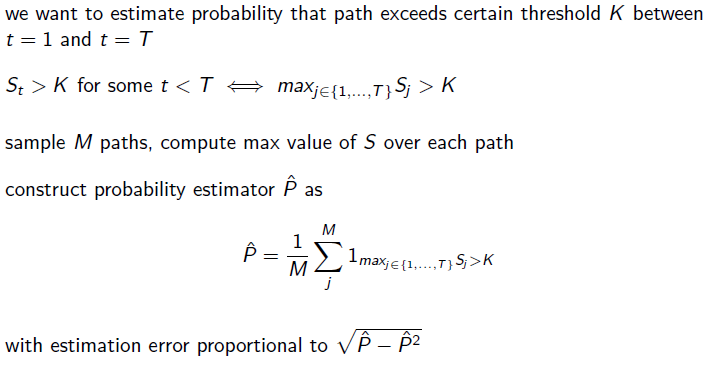

Aquí analizamos si el día dado fue inactivo. Lo que hacemos es mediante la fórmula dada en clase encontrar la proporción de 'días apagado' entre el total:

In [77]:
def inactividad_julio(k_optimo, T=365, num_simulaciones=10000):
    np.random.seed(189)
    inactividad_comun = 0
    for _ in range(num_simulaciones):
        S, D = wind_path(S_0, D_0, kappa, theta, sigma, delta, beta, gamma, T)
        _, _, _, _, inactividad_norte = simulate_molino(S + D / 2, k_optimo, T)
        _, _, _, _, inactividad_sur= simulate_molino(S - D / 2, k_optimo, T)

        if inactividad_norte[189]== 1 and inactividad_sur[189]==1 : 
            inactividad_comun += 1
    
    inactividad_comun_media = inactividad_comun / num_simulaciones
    error_estimacion = np.sqrt((inactividad_comun_media * (1 - inactividad_comun_media))/num_simulaciones)
    return inactividad_comun_media, error_estimacion

inactividad_9_julio, error_estimacion = inactividad_julio(7.5)
print(f"La probabilidad de que los dos molinos estén inactivos el 9 de julio es: {inactividad_9_julio:.5f}")
print(f"El error de estimación es: {error_estimacion:.5f}")

La probabilidad de que los dos molinos estén inactivos el 9 de julio es: 0.00090
El error de estimación es: 0.00030


En este segundo caso, encaramos el ejercicio de una manera muy similar. La única diferencia es que intentamos 'estandarizarlo' para cualquier día contando la cantidad de veces que se rompían ambos en cualquier molino.

In [75]:
def inactividad(k_optimo, T=365, num_simulaciones=10000):
    inactividad_total = 0
    np.random.seed(189)
    for _ in range(num_simulaciones):
        S, D = wind_path(S_0, D_0, kappa, theta, sigma, delta, beta, gamma, T)
        _, _, _, _, inactividad_norte = simulate_molino(S + D / 2, k_optimo, T)
        _, _, _, _, inactividad_sur = simulate_molino(S - D / 2, k_optimo, T)

        for i in range(0,365):
            inactividad_comun = 0
            if inactividad_norte[i]== 1 and inactividad_sur[i]==1 : 
                inactividad_comun += 1
        inactividad_total += inactividad_comun/365

    inactividad_comun_media = inactividad_total / num_simulaciones
    error_estimacion = np.sqrt((inactividad_comun_media * (1 - inactividad_comun_media))/num_simulaciones)


    return inactividad_comun_media, error_estimacion

inactividad, error_estandar = inactividad(7.5)
print(f"La probabilidad de que los dos molinos estén inactivos algún día del año es: {inactividad:.5f}")
print(f"El error es: {error_estandar:.5f}")

La probabilidad de que los dos molinos estén inactivos algún día del año es: 0.00143
El error es: 0.00038


# Ejercicio 12

En este caso, buscamos generar 10000 simulaciones de ingresos totales de Mayo en cada molino y calcular su promedio para luego evaluar su correlación.

    correlacion = np.corrcoef(ingresos_norte, ingresos_sur)[0, 1]


In [14]:
def simulate_molino_ingresos(S, K, T):
    cash_flow = np.zeros(T)
    roturas = np.zeros(T)
    estados = np.zeros(T)
    estado = 'apagado'
    roto = False
    apagados = np.zeros(T)
    encendidos = np.zeros(T)
    for t in range(0, T):
        if estado == 'encendido':
            prob_falla = 0.25 * (S[t] ** 2) * delta
            if np.random.random() < prob_falla:
                roto = True  # El molino se rompe
                roturas[t]=1
        if roto:
            cash_flow[t] = 0  # Costo de reparación
            roto = False  # Molino se repara en el mismo día
            estado = 'apagado'  # Se apaga después de repararse
            apagados[t] = 1
        else:
            if S[t] > K and estado == 'encendido':
                cash_flow[t] = 0 # Costo de apagar
                estado = 'apagado'
                apagados[t] = 1

            elif S[t] <= K and estado == 'apagado':
                cash_flow[t] = 1000 * S[t]  # Encender no cuesta nada
                estado = 'encendido'
                encendidos[t] = 1
                
            if estado == 'encendido':
                ingreso_diario = 1000 * S[t]
                cash_flow[t] = ingreso_diario
        
        if estado == 'apagado':
            estados[t] = 1
        
    return cash_flow

In [16]:
def ingresos_mayo(k_optimo, T= 365, num_simulaciones= 1000):
    ingresos_norte = []
    ingresos_sur = []
    np.random.seed(244)
    for _ in range(num_simulaciones):
        S, D = wind_path(S_0, D_0, kappa, theta, sigma, delta, beta, gamma, T)
        ingresos_norte = simulate_molino_ingresos(S + D / 2, k_optimo, T)
        ingresos_sur= simulate_molino_ingresos(S - D / 2, k_optimo, T)

        ingresos_norte_muestra= np.sum(ingresos_norte[120:151]) 
        ingresos_sur_muestra= np.sum(ingresos_sur[120:151])
        
        ingresos_norte.append(ingresos_norte_muestra)
        ingresos_sur.append(ingresos_sur_muestra)
    
    correlacion = np.corrcoef(ingresos_norte, ingresos_sur)[0, 1]
    
    return correlacion

correlacion = ingresos_mayo(k_max)
print(correlacion)

0.3104863899312489


# Ejercicio 13

Para este ejercicio decidimos evaluar la sensibilidad del modelo mediante la fórmula provista en las slides en clase, poniendo en evaluación la variable *costo de reparación*:

$$
\frac{\partial E[f(\alpha, Z)]}{\partial \alpha} $$

$$ 
\approx \frac{E[f(\alpha + \epsilon, Z)] - E[f(\alpha - \epsilon, Z)]}{2\epsilon}  
$$

$$
\approx \frac{\frac{1}{M} \sum_{j=1}^{M} f(\alpha + \epsilon, Z_j) - \frac{1}{M} \sum_{k=1}^{M} f(\alpha - \epsilon, Z_k)}{2\epsilon}
$$


Cambiamos función de molinos con el nuevo costo:

In [42]:
def simulate_molino_cambio(S, K, T, costo_reparacion):
    cash_flow = np.zeros(T)
    roturas = np.zeros(T)
    estados = np.zeros(T)
    estado = 'apagado'
    roto = False
    apagados = np.zeros(T)
    encendidos = np.zeros(T)
    for t in range(0, T):
        if estado == 'encendido':
            prob_falla = 0.25 * (S[t] ** 2) * delta
            if np.random.random() < prob_falla:
                roto = True  # El molino se rompe
                roturas[t]=1
        if roto:
            cash_flow[t] = -costo_reparacion   # Costo de reparación
            roto = False  # Molino se repara en el mismo día
            estado = 'apagado'  # Se apaga después de repararse
            apagados[t] = 1
        else:
            if S[t] > K and estado == 'encendido':
                cash_flow[t] = -1000  # Costo de apagar
                estado = 'apagado'
                apagados[t] = 1

            elif S[t] <= K and estado == 'apagado':
                cash_flow[t] = 1000 * S[t]  # Encender no cuesta nada
                estado = 'encendido'
                encendidos[t] = 1
                
            if estado == 'encendido':
                ingreso_diario = 1000 * S[t]
                cash_flow[t] = ingreso_diario
        
        if estado == 'apagado':
            estados[t] = 1
        
    return cash_flow, roturas, encendidos, apagados, estados

In [25]:
def sensibilidad_van_costo_reparacion(k, costo_reparacion, epsilon, num_simulaciones):
    van_mas = 0
    van_menos = 0
    for i in range(num_simulaciones):
        S, D = wind_path(S_0, D_0, kappa, theta, sigma, delta, beta, gamma, T)
        
        # VAN con costo de reparación (C + epsilon)
        cash_flow_norte_mas, _, _, _, _ = simulate_molino_cambio(S + D / 2, k, T, costo_reparacion + epsilon)
        cash_flow_sur_mas, _, _, _, _ = simulate_molino_cambio(S - D / 2, k, T, costo_reparacion + epsilon)
        cash_flow_total_mas = cash_flow_norte_mas + cash_flow_sur_mas
        van = calcular_van(cash_flow_total_mas, tasa_interes, T)
        van_mas = van_mas + van
        
        # VAN con costo de reparación (C - epsilon)
        cash_flow_norte_menos, _, _, _, _ = simulate_molino_cambio(S + D / 2, k, T, costo_reparacion - epsilon)
        cash_flow_sur_menos, _, _, _, _ = simulate_molino_cambio(S - D / 2, k, T, costo_reparacion - epsilon)
        cash_flow_total_menos = cash_flow_norte_menos + cash_flow_sur_menos
        van = calcular_van(cash_flow_total_menos, tasa_interes, T)
        van_menos = van_menos + van

    # Promedio de los VAN calculados
    van_mas_promedio = van_mas / num_simulaciones
    van_menos_promedio = van_menos / num_simulaciones
    
    # Sensibilidad del VAN respecto al costo de reparación
    sensibilidad = (van_mas_promedio - van_menos_promedio) / (2 * epsilon)
    
    return sensibilidad

In [28]:
# Parámetros para la sensibilidad
num_simulaciones = 10000
k_optimo = k_max  
costo_reparacion = 200000 
epsilon = 1000 

# Calcular la sensibilidad del VAN respecto al costo de reparación
sensibilidad = sensibilidad_van_costo_reparacion(k_optimo, costo_reparacion, epsilon, num_simulaciones)

print(f"Sensibilidad del VAN respecto al costo de reparación: {sensibilidad:.2f} USD por dólar de cambio en el costo de reparación.")


Sensibilidad del VAN respecto al costo de reparación: -11.79 USD por dólar de cambio en el costo de reparación.


Vemos que el resultado tiene sentido: a mayor costo de reparación, nuestro VAN va a ser menor. Y es super intuitivo pensar que el K óptimo va a ser menor, así que para esto vemos como cambia:

In [43]:

def k_optimo(num_simulaciones):
    np.random.seed(20)
    k_max = None  # Inicializa el mejor K como None
    van_max = -np.inf  # Inicializa el VAN máximo como un valor muy bajo
    error_estandar_max = 0  
    for k in np.arange(1, 13, 0.25):
        van_lista = []  # Lista para almacenar los VAN de cada simulación
        for i in range(num_simulaciones):
            S, D = wind_path(S_0, D_0, kappa, theta, sigma, delta, beta, gamma, T)
            cash_flow_norte, _, _, _, _ = simulate_molino_cambio(S + D / 2, k, T, 250000)
            cash_flow_sur, _, _, _, _ = simulate_molino_cambio(S - D / 2, k, T, 250000)
            cash_flow_total = cash_flow_norte + cash_flow_sur
            van = calcular_van(cash_flow_total, tasa_interes, T)  # Calcula el VAN del cash flow total
            van_lista.append(van)
        
        van_total = np.mean(van_lista)  
        std_van = np.std(van_lista)  
        error_estandar = std_van / np.sqrt(num_simulaciones) 
        
        if van_total > van_max:  
            van_max = van_total
            k_max = k
            error_estandar_max = error_estandar

    return k_max, van_max, error_estandar_max

# Ejecutar la función
num_simulaciones = 1000
k_max, van_promedio, error_estandar_max = k_optimo(num_simulaciones)

# Mostrar resultados
print(f"El umbral K óptimo promedio es: {k_max}")
print(f"El VAN promedio es: {van_promedio:.2f} USD")
print(f"El error estándar del VAN óptimo es: {error_estandar_max:.2f} USD")

El umbral K óptimo promedio es: 5.5
El VAN promedio es: 158427.39 USD
El error estándar del VAN óptimo es: 15533.25 USD


Como vemos, el K óptimo bajó de manera drástica debido al aumento de los costos de reparación. Este umbral es una respuesta a intentar bajar las probabilidades de roturas de molinos.

# Ejercicio 14


Para este ejercicio vamos a tener dos formas diferentes de ver esto:
- En primer lugar, vamos a intenar graficar la evolución del VAN acumulado a lo largo del año y ver en que momentos crece más/menos según la media estacional.

- En segundo lugar, veamos si cambiamos el valor de theta modificando la función en sí.

In [34]:
# Definir la θ(t)
def theta(i):
    return 6 + 2 * math.cos(2*math.pi * (i-1)/365)

# Calcular θ(t) para cada día
data['theta'] = data['dia'].apply(theta)
data.head()

,dia,regional wind,wind gap norte sur,wind_increase,theta,gap_dif
0,1,8.000000,0.000000,NaN,8.000000,NaN
1,2,8.346296,0.181523,0.346296,7.999704,0.181523
2,3,10.062316,0.188643,1.716019,7.998815,0.007120
3,4,10.791337,0.071085,0.729021,7.997334,-0.117558
4,5,10.754093,0.078442,-0.037244,7.995261,0.007358


In [44]:
def VAN_acumulado(num_simulaciones, K): 
    np.random.seed(20)
    van_total = 0
    van = 0
    van_promedio
    cash_flow_total = np.zeros(365)
    for i in range(num_simulaciones):
        S, D = wind_path(S_0, D_0, kappa, theta, sigma, delta, beta, gamma, T)
        cash_flow_norte, _, _, _, _ = simulate_molino(S + D / 2, K, T)
        cash_flow_sur, _, _, _, _= simulate_molino(S - D / 2, K, T)
        cash_flow_total = cash_flow_norte + cash_flow_sur
        van = cash_flow_total * np.exp(-tasa_interes * np.arange(T) / 365)
        van_total += van

    van_acumulado = np.cumsum(van_total / num_simulaciones)

    return van_acumulado

# Ejecutar la función
num_simulaciones = 10000
k = 7.5
van_acumulado= VAN_acumulado(num_simulaciones, K)
van_acumulado = van_acumulado / 100000
print(van_acumulado)

[ 0.00000000e+00  4.00798975e-02  4.14403723e-02  3.30271369e-02
  2.67512336e-02  2.16027296e-02  1.43614743e-02  1.08275039e-02
  6.60246371e-03  3.78443874e-03  8.58178121e-03  6.66265825e-03
  9.54623220e-04 -2.02244341e-03 -9.86050060e-03 -1.23603143e-02
 -1.51501674e-02 -1.92141206e-02 -2.12977407e-02 -1.66066345e-02
 -1.58962195e-02 -1.79069340e-02 -2.00544359e-02 -1.84033447e-02
 -1.67303242e-02 -1.87668364e-02 -2.42491563e-02 -2.98148387e-02
 -3.44547518e-02 -4.31820618e-02 -4.59181243e-02 -4.99150778e-02
 -5.10996087e-02 -5.59765932e-02 -6.51320328e-02 -6.71809160e-02
 -6.88063073e-02 -7.32007864e-02 -7.76622221e-02 -7.05630023e-02
 -7.09515983e-02 -7.23782509e-02 -7.39150557e-02 -7.44065986e-02
 -7.13064384e-02 -6.25577057e-02 -6.09438293e-02 -5.70952719e-02
 -6.42101616e-02 -5.08036460e-02 -5.23957552e-02 -4.90044642e-02
 -5.45700715e-02 -6.02142702e-02 -6.36950220e-02 -5.61440373e-02
 -5.37818948e-02 -4.93523890e-02 -4.64650890e-02 -3.82700438e-02
 -3.76696525e-02 -3.29323

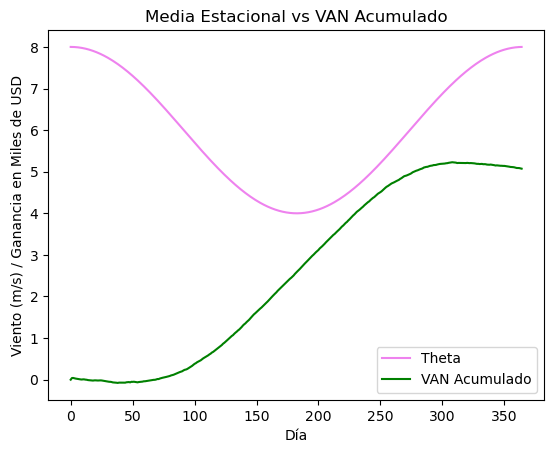

In [49]:
plt.plot(data['theta'][0:365],label='Theta', color='violet')
plt.plot(van_acumulado, label = 'VAN Acumulado', color = 'green')
plt.title('Media Estacional vs VAN Acumulado')
plt.xlabel('Día')
plt.ylabel('Viento (m/s) / Ganancia en Miles de USD')
plt.legend()
plt.show()

Nuestros resultados son consistentes: 
Observamos que durante los días con menor media estacional crece muchísimo más nuestro VAN acumulado debido al menor riesgo de roturas o de apagar el molino. 

In [ ]:
theta_2 = data['theta']

In [26]:
def k_optimo(num_simulaciones, theta):
    np.random.seed(20)
    k_max = None  # Inicializa el mejor K como None
    van_max = -np.inf  # Inicializa el VAN máximo como un valor muy bajo
    error_estandar_max = 0  
    for k in np.arange(1, 13, 0.25):
        van_lista = []  # Lista para almacenar los VAN de cada simulación
        for i in range(num_simulaciones):
            S, D = wind_path(S_0, D_0, kappa, theta, sigma, delta, beta, gamma, T)
            cash_flow_norte, _, _, _, _ = simulate_molino(S + D / 2, k, T)
            cash_flow_sur, _, _, _, _ = simulate_molino(S - D / 2, k, T)
            cash_flow_total = cash_flow_norte + cash_flow_sur
            van = calcular_van(cash_flow_total, tasa_interes, T)  # Calcula el VAN del cash flow total
            van_lista.append(van)
        
        van_total = np.mean(van_lista)  
        std_van = np.std(van_lista)  
        error_estandar = std_van / np.sqrt(num_simulaciones) 
        
        if van_total > van_max:  
            van_max = van_total
            k_max = k
            error_estandar_max = error_estandar

    return k_max, van_max, error_estandar_max

# Ejecutar la función
num_simulaciones = 10000
k_max, van_promedio, error_estandar_max = k_optimo(num_simulaciones, theta_2)

# Mostrar resultados
print(f"El umbral K óptimo promedio es: {k_max}")
print(f"El VAN promedio es: {van_promedio:.2f} USD")
print(f"El error estándar del VAN óptimo es: {error_estandar_max:.2f} USD")


El umbral K óptimo promedio es: 7.25
El VAN promedio es: 91311.09 USD


In [27]:
def VAN_estimado_k(num_simulaciones, K, theta): 
    np.random.seed(20)
    van_total = 0
    van_lista = []
    for i in range(num_simulaciones):
        S, D = wind_path(S_0, D_0, kappa, theta, sigma, delta, beta, gamma, T)
        cash_flow_norte, _, _, _, _ = simulate_molino(S + D / 2, K, T)
        cash_flow_sur, _, _, _, _= simulate_molino(S - D / 2, K, T)
        cash_flow_total = cash_flow_norte + cash_flow_sur
        van = calcular_van(cash_flow_total, tasa_interes, T)  # Calcula el VAN del cash flow total
        van_total = van_total + van
        van_lista.append(van)
    van_total = van_total / num_simulaciones
    return van_total, np.std(van_lista)

# Ejecutar la función
num_simulaciones = 10000
k = k_max
van_K, std_van_K = VAN_estimado_k(num_simulaciones, K, theta_2)

# Mostrar resultados
print(f"El VAN promedio es: {van_K:.2f} USD")
print(f"El Error estándar  es: {std_van_K:.2f} USD")


El VAN promedio es: 68873.02 USD
El Error estándar  es: 557597.02 USD


En este segundo ejemplo vemos que subiendo el valor constante de Theta de 6 a 8 (aumentando la media estacional) nuestro K óptimo y VAN promedio cambia de manera negativa: el nuevo umbral es menor buscando protegerse más del viento y el VAN promedio es menor (ya que mayores vientos rompen más los molinos).